# Problem statement

- Building a sentiment analysis model to analyse customer reviews and feedback for a hospitality company.
- The model should be able to classify reviews as positive, negative or neutral

In [7]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%pip install pandas matplotlib seaborn nltk wordcloud scikit-learn keras

     --------------------------------------- 11.6/11.6 MB 32.8 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 28.6 MB/s eta 0:00:00
     ---------------------------------------- 294.9/294.9 kB ? eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 24.1 MB/s eta 0:00:00
     ------------------------------------- 299.8/299.8 kB 19.3 MB/s eta 0:00:00
     --------------------------------------- 11.1/11.1 MB 36.4 MB/s eta 0:00:00
     ------------------------------------- 347.8/347.8 kB 21.1 MB/s eta 0:00:00
     ------------------------------------- 509.2/509.2 kB 16.1 MB/s eta 0:00:00
     ------------------------------------- 221.2/221.2 kB 13.2 MB/s eta 0:00:00
     ---------------------------------------- 111.1/111.1 kB ? eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 28.4 MB/s eta 0:00:00
     ---------------------------------------- 71.9/71.9 kB ? eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 17.


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
import pickle
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize,sent_tokenize
import sklearn
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,LSTM,GRU,Embedding,InputLayer,Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import  BernoulliNB,MultinomialNB,CategoricalNB

## Data Collection

In [34]:
data_set = pd.read_csv(r"tripadvisor_hotel_reviews.csv")
data_set.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Data Exploration

- Explore the Sentiment dataset to understand its structure, features, and size.

In [35]:
# Making a copy of the dataset so as not to change the original dataframe.
df = data_set.copy()
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [36]:
# checking shape of the dataset
df.shape

(20491, 2)

In [37]:
# checking information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [38]:
# Checking if there are any duplicates present in the dataset
df.duplicated().sum()

np.int64(0)

In [39]:
# checking for any null values in the dataset.
df.isnull().sum()

Review    0
Rating    0
dtype: int64

#### About  dataset
- The dataset contains two columns of review and rating
- Review  - This reviews are provided based on the customers stay at that paticular hotel
- Ratings - This ratings are given by the customers on the bases of there stay in the hotel 

`we can see that the dataset doesnot contain any of the duplicate and null value.If there are any null value we can use imputation techniques for fill the null values and for duplicate we can remove them.`

### Exploratory Data Analysis (EDA)

In [40]:
target_class_count = df['Rating'].value_counts()
target_class_count

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

C:\Users\GuruCharan\AppData\Local\Temp\ipykernel_22356\2923175143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,


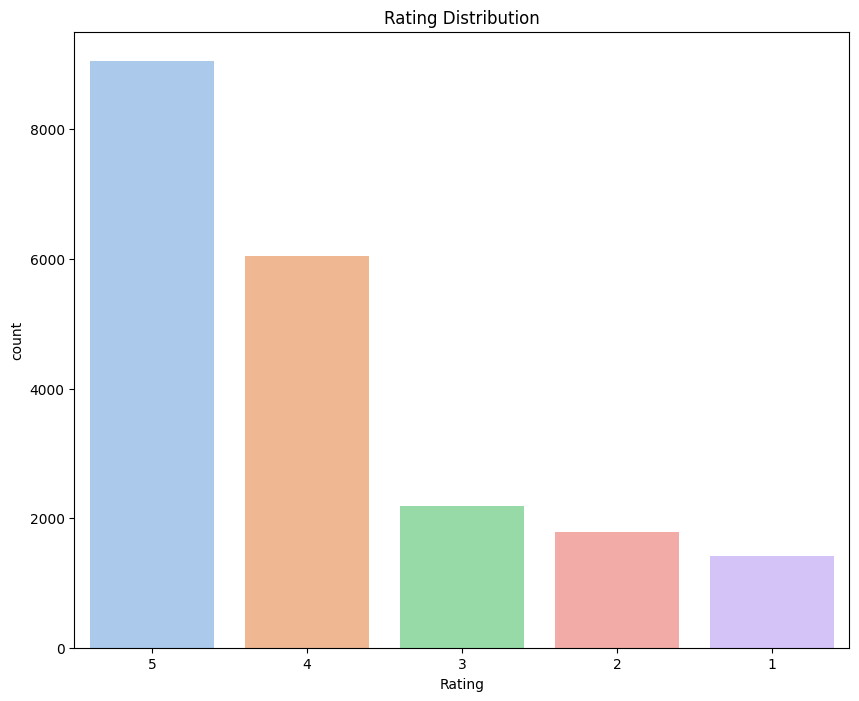

In [41]:
plt.figure(figsize=(10,8))
sns.countplot(data=df,
                x='Rating',
              palette="pastel",
              order = df['Rating'].value_counts().index)
plt.title('Rating Distribution')
plt.show()

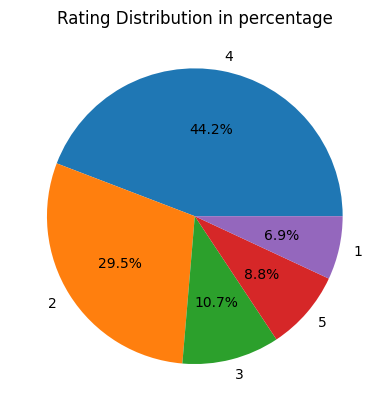

In [42]:
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.title('Rating Distribution in percentage')
plt.show()

## Text Preprocessing:

`Because the data is uneven, there's a probability that the model we develop may lean toward positive reviews, which is why I'm using rating column 4 only rather than both 4 and 5 as positive reviews.`

In [43]:
df['Rating'].value_counts()

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

In [44]:
df = df[df['Rating'] != 5]
df['Rating'].value_counts()
df.reset_index(drop=True, inplace=True)
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"excellent staff, housekeeping quality hotel ch...",4
4,"poor value stayed monaco seattle july, nice ho...",2
...,...,...
11432,not impressed unfriendly staff checked asked h...,2
11433,great location price view hotel great quick pl...,4
11434,"ok just looks nice modern outside, desk staff ...",2
11435,hotel theft ruined vacation hotel opened sept ...,1


- Preprocess reviews text by removing stop words, special characters, and URLs.
- Tokenize and lemmatize words to prepare the text for sentiment analysis.

In [45]:
df.Review

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        excellent staff, housekeeping quality hotel ch...
4        poor value stayed monaco seattle july, nice ho...
                               ...                        
11432    not impressed unfriendly staff checked asked h...
11433    great location price view hotel great quick pl...
11434    ok just looks nice modern outside, desk staff ...
11435    hotel theft ruined vacation hotel opened sept ...
11436    people talking, ca n't believe excellent ratin...
Name: Review, Length: 11437, dtype: object

In [46]:
df_review=df['Review']

In [47]:
#Checking whether the given data is in correct text formate or not by creating a custom function
def checking_data(data):
    case=' '.join(data).islower()
    html = data.apply(lambda x:True if re.findall("<.+?>",x)else False).sum()
    urls = data.apply(lambda x:True if re.findall("http[s]?://.+? +",x)else False).sum()
    unwanted_ = data.apply(lambda x:True if re.findall("[]()*\-.,@#$%^&0-9]",x)else False).sum()
    if case==False:
        print('not in lower case')
    if html>0:
        print('have html tags')
    if urls>0:
        print('have urls ')
    if unwanted_>0:
        print('having unwanted characters')
    else:
        print("Nothing to do with data.The data is clean now.")

In [48]:
checking_data(df_review)

not in lower case
having unwanted characters


- As the data is not in lower case and having unwanted charters we need to make it into lower case and need to remove unwanted  characters

In [49]:
# creating a different funtion to make the dataset into lower case ,removing unwanted  charters and 

In [50]:
def lowercase(x):
     return x.str.lower()

In [51]:
def unwanted_characters(x):
    x = x.apply(lambda x : re.sub("[^a-z\s]"," ",x))
    return x

In [52]:
# lemmatization is a techinque used to remove the stopwords present the reviews data(text data)
def lemmatization(x):
    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()
    def lemmatize_text(text):
        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)
    return x.apply(lemmatize_text)

In [53]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GuruCharan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GuruCharan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GuruCharan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
#creating a pipepline to preprocess the data 
preprocesser_pipeline = Pipeline([('Lowercase', FunctionTransformer(lowercase)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

In [55]:
final_reviews = preprocesser_pipeline.fit_transform(df['Review'])

In [56]:
checking_data(final_reviews)

Nothing to do with data.The data is clean now.


In [57]:
final_df = pd.concat([pd.DataFrame(final_reviews,columns= ['Review']),df['Rating']],axis=1)

In [58]:
final_df.sample(4)

,Review,Rating
4238,fabulous stay pick hotel price location review...,4
4197,nice boyfriend vacation secrets june service n...,4
2650,picture perfect return week paris day trip bru...,4
6172,average hotel average price stay hotel prins h...,3


### EDA after preprocessing the Data

In [59]:
positive_reviews= final_df[final_df['Rating'] == 4]['Review']
negative_reviews= final_df[final_df['Rating'] <= 2]['Review']
netural_reviews = final_df[final_df['Rating'] == 3]['Review']

In [60]:
wl = WordNetLemmatizer()

In [61]:
pos_rev = wl.lemmatize(' '.join(positive_reviews))
neg_rev = wl.lemmatize(' '.join(negative_reviews))
net_rev = wl.lemmatize(' '.join(netural_reviews))

### By using word cloud we can generate the most common words appeared  in different reviews columns

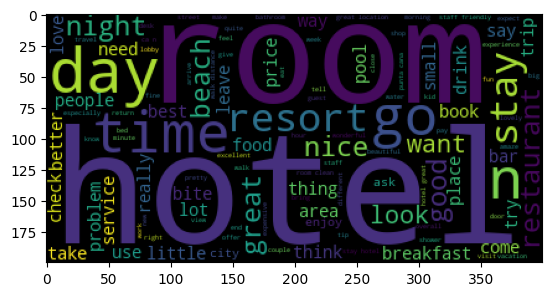

In [62]:
#pass the entire single sting having all positive reviews
wc = WordCloud().generate(pos_rev)
plt.imshow(wc)
plt.show()

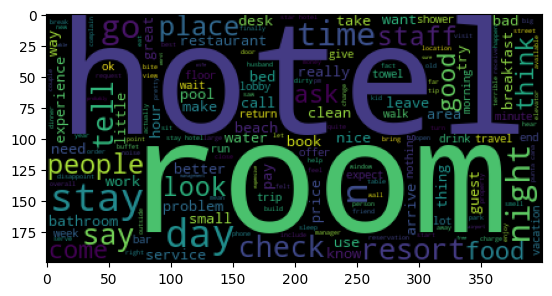

In [63]:
#pass the entire single sting having all negative_reviews
wc = WordCloud().generate(neg_rev)
plt.imshow(wc)
plt.show()

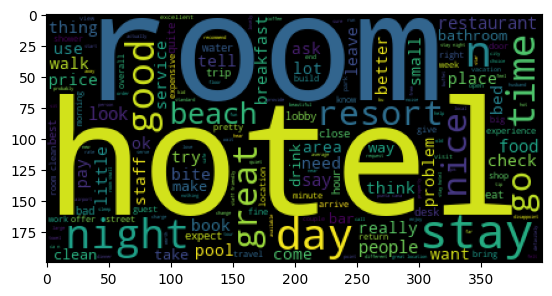

In [64]:
#pass the entire single sting having all netural_reviews
wc = WordCloud().generate(net_rev)
plt.imshow(wc)
plt.show()

In [65]:
final_df

,Review,Rating
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,2
2,nice room experience hotel monaco seattle good...,3
3,excellent staff housekeep quality hotel chock ...,4
4,poor value stay monaco seattle july nice hotel...,2
...,...,...
11432,impress unfriendly staff check ask higher floo...,2
11433,great location price view hotel great quick pl...,4
11434,ok look nice modern outside desk staff n parti...,2
11435,hotel theft ruin vacation hotel open sept gues...,1


In [66]:
# Correct spelling and use vectorized operations
final_df.loc[final_df['Rating'] == 4, 'Rating'] = 'Positive'
final_df.loc[final_df['Rating'] == 3, 'Rating'] = 'Neutral'
final_df.loc[final_df['Rating'] == 2, 'Rating'] = 'Negative'
final_df.loc[final_df['Rating'] == 1, 'Rating'] = 'Negative'

C:\Users\GuruCharan\AppData\Local\Temp\ipykernel_22356\3815766103.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Positive' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_df.loc[final_df['Rating'] == 4, 'Rating'] = 'Positive'


In [67]:
final_df

,Review,Rating
0,nice hotel expensive park get good deal stay h...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice room experience hotel monaco seattle good...,Neutral
3,excellent staff housekeep quality hotel chock ...,Positive
4,poor value stay monaco seattle july nice hotel...,Negative
...,...,...
11432,impress unfriendly staff check ask higher floo...,Negative
11433,great location price view hotel great quick pl...,Positive
11434,ok look nice modern outside desk staff n parti...,Negative
11435,hotel theft ruin vacation hotel open sept gues...,Negative


## Feature Engineering

In [68]:
x_train,x_test,y_train,y_test = train_test_split(final_df['Review'],final_df['Rating'],random_state=30,test_size=0.2,stratify=final_df['Rating'])
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,random_state=30,test_size=0.2,stratify=y_train)

In [69]:
y_train.value_counts()

Rating
Positive    3865
Negative    2057
Neutral     1397
Name: count, dtype: int64

### Checking No. of words in each sentence of Review column

In [70]:
sentence_length = []
for sent in final_df['Review']:
    sentence_length.append(len(word_tokenize(sent)))
final_df['sent_length'] = sentence_length
final_df.head()

,Review,Rating,sent_length
0,nice hotel expensive park get good deal stay h...,Positive,81
1,ok nothing special charge diamond member hilto...,Negative,232
2,nice room experience hotel monaco seattle good...,Neutral,202
3,excellent staff housekeep quality hotel chock ...,Positive,86
4,poor value stay monaco seattle july nice hotel...,Negative,44


In [71]:
max(final_df['sent_length'])

1889

In [72]:
final_df['sent_length'].value_counts(ascending = True)

sent_length
742       1
598       1
1179      1
791       1
1396      1
       ... 
58      112
56      112
51      116
60      119
69      122
Name: count, Length: 552, dtype: int64

In [73]:
np.quantile(final_df['sent_length'],0.95)

np.float64(283.0)

In [74]:
# Since 283 is the maximum sentence length in 95% of the data, we utilize that as the maximum length.
max_length = 283

In [75]:
le = LabelEncoder()
Y_train = le.fit_transform(y_train)
Y_test = le.transform(y_test)

In [76]:
Y_cv = le.transform(y_cv)

### Tokenization, Vectorization & Padding Sequence

In [77]:
# Word tokenizer
sent_tk = Tokenizer(oov_token='None')

In [78]:
sent_tk.fit_on_texts(x_train)

In [79]:
# Total No. of Unique words in our dataset
vocab_len =len(sent_tk.word_counts)
vocab_len

25524

In [80]:
# Putting all index/unique id of each words in a sequence according to the data
seque_xtrain = sent_tk.texts_to_sequences(x_train)
len(seque_xtrain)

7319

In [81]:
seque_x_cv = sent_tk.texts_to_sequences(x_cv)
len(seque_x_cv)

1830

In [82]:
# Padding the Sequence data to make the dimensionalty to 
final_x_train =  pad_sequences(seque_xtrain,maxlen=max_length)
final_x_train.shape

(7319, 283)

In [83]:
final_x_cv =  pad_sequences(seque_x_cv,maxlen=max_length)
final_x_cv.shape

(1830, 283)

## Model Building (Neural Network)

In [84]:
# model = Sequential()
# model.add(InputLayer((283,)))
# # Embedding
# model.add(Embedding(25444,500))
# # LSTM Layer
# model.add(LSTM(20,activation='tanh'))
# model.add(Dense(10,activation="relu"))
# model.add(Dropout(0.5))
# # Output Layer
# model.add(Dense(3,activation="softmax"))

In [85]:
# # Summary of our model
# model.summary()

In [86]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
# er = EarlyStopping(patience=3)

In [88]:
# trained_model = model.fit(final_x_train,Y_train,batch_size=15,epochs=20,validation_data=(final_x_cv,Y_cv),callbacks=[er])

In [89]:
# seque_xtest = sent_tk.texts_to_sequences(x_test)
# final_x_test =  pad_sequences(seque_xtest,maxlen=max_length)
# final_x_test.shape

In [90]:
# y_pred = model.predict(final_x_test)

In [91]:
# y_pred.shape

In [92]:
# Y_test.shape

In [93]:
# y_pred

In [94]:
# accuracy_score(Y_test,np.argmax(y_pred,axis=1))

In [95]:
# print(classification_report(Y_test,np.argmax(y_pred,axis=1)))

In [96]:
# model.save(r"C:\Users\Ranjith\OneDrive\Desktop\Prudent\LSTM.keras")

## Using Machine Learning

In [97]:
#Model1
cv1=CountVectorizer()

In [98]:
fbow=cv1.fit_transform(x_train)

### Using Bernoulli Naive Bayes with CountVectorizer

In [103]:
b =BernoulliNB(alpha = 0.1)
final_model=b.fit(fbow,y_train)
final_model.predict(cv1.transform(x_test))
accuracy_score((y_test),final_model.predict(cv1.transform(x_test)))

0.6993006993006993

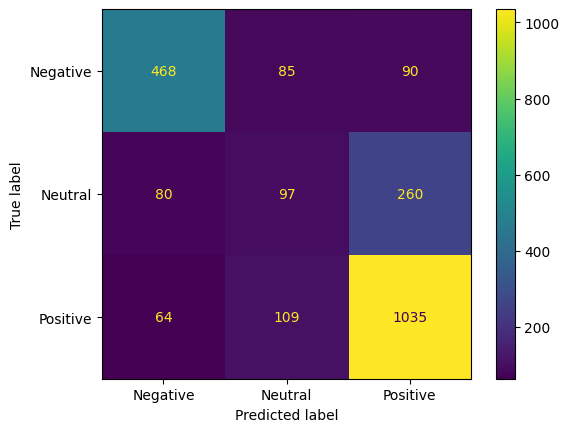

In [104]:
cm = confusion_matrix(y_test,final_model.predict(cv1.transform(x_test)))
i = ConfusionMatrixDisplay(cm,display_labels=b.classes_)
i.plot()
plt.show()

### Using Multinomial Naive Bayes with CountVectorizer

In [105]:
mn =MultinomialNB(alpha = 0.1)
final_model1=mn.fit(fbow,y_train)
final_model1.predict(cv1.transform(x_test))
accuracy_score((y_test),final_model.predict(cv1.transform(x_test)))

0.6993006993006993

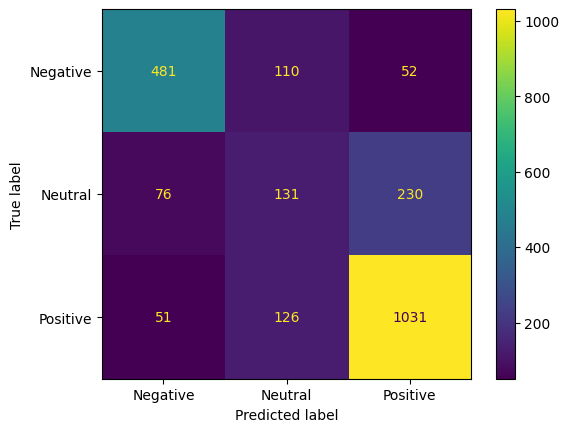

In [106]:
cm = confusion_matrix(y_test,final_model1.predict(cv1.transform(x_test)))
i = ConfusionMatrixDisplay(cm,display_labels=b.classes_)
i.plot()
plt.show()

In [107]:
tf_idf = TfidfVectorizer()
fbow1 = tf_idf.fit_transform(x_train)

### Using Bernoulli Naive Bayes with TfidfVectorizer

In [108]:
b =BernoulliNB(alpha = 0.1)
final_model=b.fit(fbow1,y_train)
final_model.predict(tf_idf.transform(x_test))
accuracy_score((y_test),final_model.predict(tf_idf.transform(x_test)))

0.6993006993006993

### Using Multinomial Naive Bayes with TfidfVectorizer

In [109]:
mn =MultinomialNB(alpha = 0.1)
final_model1=mn.fit(fbow1,y_train)
final_model1.predict(tf_idf.transform(x_test))
accuracy_score((y_test),final_model.predict(tf_idf.transform(x_test)))

0.6993006993006993

In [111]:
# with open(r"C:\Users\Ranjith\OneDrive\Desktop\Prudent\BernoulliNB.pkl", "wb") as file:
#     pickle.dump(final_model, file)

In [112]:
x_test

810      look shabby large hotel absolutely room servic...
4901     stay hotel nights week pros con pros away tour...
10355    ok hotel reserve platinum room upgrade suite n...
3712     great place price definitely right check iberv...
3245     surprise surprise good review hotel get locati...
                               ...                        
2034     great recently take group people puerto rico s...
7625     worst inclusive resort punta cana resort worse...
6431     funky modern room great stay adrema room moder...
6821     location location stay nights wife sept great ...
2091     stay stay group people person ceiling bathroom...
Name: Review, Length: 2288, dtype: object